# Autistic Face Reader (Part 1)

### 0: Import Libraries

In [1]:
#magic command
%matplotlib inline

# for Data Import
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
## from PIL import Image
## from skimage import transform

# for Data Overview
import glob as gb

# for Exploratory Data Analysis
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.decomposition import PCA
from math import ceil

2023-02-07 15:35:07.787551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 1: Import Data

In [2]:
photo_size=224

In [3]:
def prepare_dataset(data_dir):
    datagen = ImageDataGenerator(
        rescale=1 / 255,
        rotation_range=40,
        width_shift_range=.2,
        height_shift_range=.2,
        shear_range=.1,
        horizontal_flip=True,
        fill_mode='nearest',
        zoom_range=.2,
    )
    generator = datagen.flow_from_directory(
        data_dir,
        target_size=(photo_size,photo_size),
        class_mode='binary',
        batch_size=128,
        classes=['non_autistic','autistic']
    )
    return generator

In [4]:
train_data=prepare_dataset('./data/train/')
valid_data = prepare_dataset('./data/valid/')
test_data=prepare_dataset('./data/test/')

Found 2530 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


### 2: Data Overview

In [5]:
train_path = './data/'
valid_path ='./data/'
test_path = './data/'

In [6]:
# train data
for folder in  os.listdir(train_path + 'train') : 
    files = gb.glob(pathname= str( train_path +'train//' + folder + '/*.jpg'))
    print(f'For training data , found {len(files)} in folder labelled "{folder}"')

For training data , found 1265 in folder labelled "autistic"
For training data , found 1265 in folder labelled "non_autistic"


In [7]:
# validation data
for folder in  os.listdir(train_path + 'valid') : 
    files = gb.glob(pathname= str( train_path +'valid//' + folder + '/*.jpg'))
    print(f'For validation data , found {len(files)} in folder labelled "{folder}"')

For validation data , found 50 in folder labelled "autistic"
For validation data , found 50 in folder labelled "non_autistic"


In [8]:
# test data
for folder in  os.listdir(train_path + 'test') : 
    files = gb.glob(pathname= str( train_path +'test//' + folder + '/*.jpg'))
    print(f'For testing data , found {len(files)} in folder labelled "{folder}"')

For testing data , found 150 in folder labelled "autistic"
For testing data , found 150 in folder labelled "non_autistic"


### 3: Exploratory Data Analysis

`1. View Randomly Sampled images`

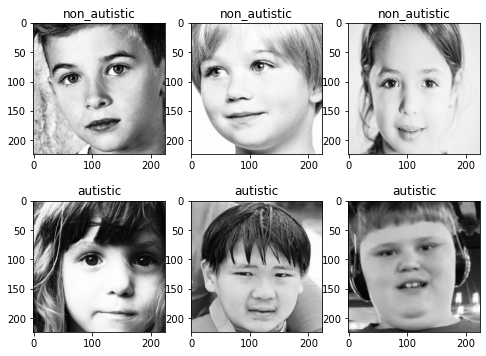

(1265, 1265)

In [9]:
train_dir = './data/train/' # image folder

# get the list of jpegs from sub image class folders
nonautistic_imgs = [fn for fn in os.listdir(f'{train_dir}/non_autistic') if fn.endswith('.jpg')]
autistic_imgs = [fn for fn in os.listdir(f'{train_dir}/autistic') if fn.endswith('.jpg')]

# randomly select 3 of each
random.seed(20)
select_nona = np.random.choice(nonautistic_imgs, 3, replace = False)
random.seed(20)
select_auti = np.random.choice(autistic_imgs, 3, replace = False)

# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/non_autistic/{select_nona[i]}'
        label = 'non_autistic'
    else:
        fp = f'{train_dir}/autistic/{select_auti[i-3]}'
        label = 'autistic'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = None, color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('on')
plt.show()

# also check the number of files here
len(nonautistic_imgs), len(autistic_imgs)

`2. Turn Images into Matrix`

In [10]:
# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # converts image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
nonautistic_images = img2np(f'{train_dir}/non_autistic/', nonautistic_imgs)
autistic_images = img2np(f'{train_dir}/autistic/', autistic_imgs)

`3. View Average Image for each Class`

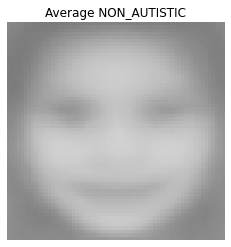

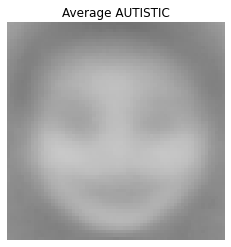

In [11]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

nonautistic_mean = find_mean_img(nonautistic_images, 'NON_AUTISTIC') 
autistic_mean = find_mean_img(autistic_images, 'AUTISTIC')

`4. Highlight contrast between autistic and non_autistic faces`

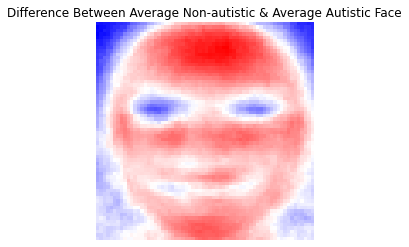

In [12]:
contrast_mean = nonautistic_mean - autistic_mean
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between Average Non-autistic & Average Autistic Face')
plt.axis('off')
plt.show()

`5. View Variance within each Class`

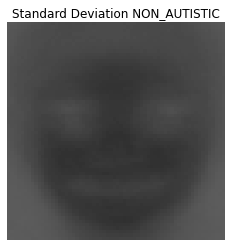

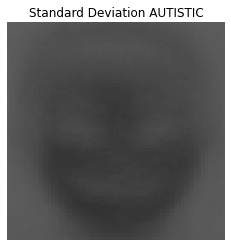

In [13]:
def find_stdev_img(full_mat, title, size = (64, 64)):
    # calculate the average
    stdev_img = np.std(full_mat, axis = 0)
    # reshape it back to a matrix
    stdev_img = stdev_img.reshape(size)
    plt.imshow(stdev_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Standard Deviation {title}')
    plt.axis('off')
    plt.show()
    return stdev_img

nonautistic_stdev = find_stdev_img(nonautistic_images, 'NON_AUTISTIC')
autistic_stdev = find_stdev_img(autistic_images, 'AUTISTIC')

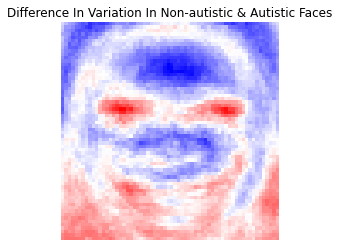

In [14]:
contrast_stdev = nonautistic_stdev - autistic_stdev
plt.imshow(contrast_stdev, cmap='bwr')
plt.title(f'Difference In Variation In Non-autistic & Autistic Faces')
plt.axis('off')
plt.show()

`6. Apply PCA to extract Eigenfaces`

In [15]:
def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca

Number of PC:  22


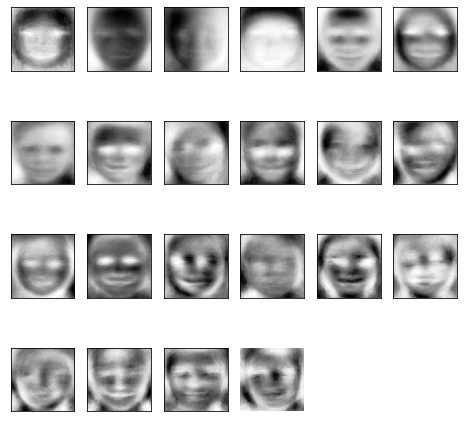

Number of PC:  28


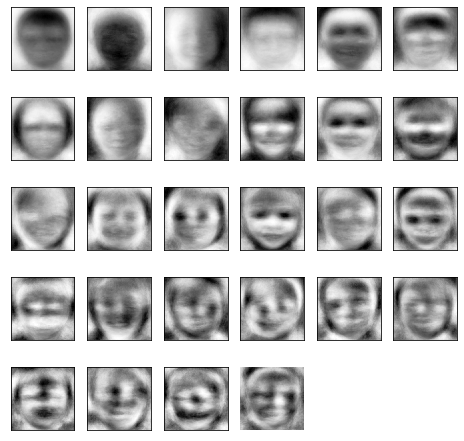

In [16]:
def plot_pca(pca, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
plot_pca(eigenimages(nonautistic_images, 'NON_AUTISTIC'))
plot_pca(eigenimages(autistic_images, 'AUTISTIC'))